In [1]:
!pip install -q transformers datasets accelerate

error: incomplete-download

× Download failed because not enough bytes were received (216.5 MB/821.0 MB)
╰─> URL: https://files.pythonhosted.org/packages/3a/24/efe2f520d75274fc06b695c616415a1e8a1021d87a13c68ff9dce733d088/torch-2.7.1-cp313-cp313-manylinux_2_28_x86_64.whl

note: This is an issue with network connectivity, not pip.
hint: Consider using --resume-retries to enable download resumption.


In [2]:
!pip install -q spacy
!python -m spacy download en_core_web_sm


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 23.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Importing libraries

In [3]:
import os
os.environ["WANDB_DISABLED"] = "true"

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback
from datasets import load_from_disk
from datasets import Dataset
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import spacy

nlp = spacy.load("en_core_web_sm")

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:251: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(
E0000 00:00:1750642705.023019      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


# Reading the Data

In [4]:
data = pd.read_csv("/kaggle/input/sentiment-analysis-dataset/sentiment_data.csv",index_col=0)
active_data = data.copy()

We preserve the original raw dataset in `data` and create a working copy called `active_data` for all preprocessing steps. 

This ensures the original data remains untouched and allows safe experimentation or reprocessing later.

In [5]:
active_data.head()

,Comment,Sentiment
0,lets forget apple pay required brand new iphon...,1
1,nz retailers don’t even contactless credit car...,0
2,forever acknowledge channel help lessons ideas...,2
3,whenever go place doesn’t take apple pay doesn...,0
4,apple pay convenient secure easy use used kore...,2


In [6]:
active_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 241145 entries, 0 to 241925
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Comment    240928 non-null  object
 1   Sentiment  241145 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.5+ MB


We observed that while the dataset contains 241,145 rows, only 240,928 of them have entries in the `Comment` column. This means 217 rows are missing the actual comment text, which is a critical input for our sentiment classification task. 

Since text-based models like BERT cannot operate on missing input, we will remove these rows to maintain data quality and avoid issues during tokenization and training.


In [7]:
active_data = active_data.dropna(subset=['Comment'])

# EDA

Before preparing the data for training, it's essential to perform basic exploratory data analysis (EDA) to better understand the distribution of sentiment classes. This helps us identify any class imbalance, which can significantly affect model performance and evaluation metrics.

/tmp/ipykernel_10/3639157558.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=active_data, palette='Set2')


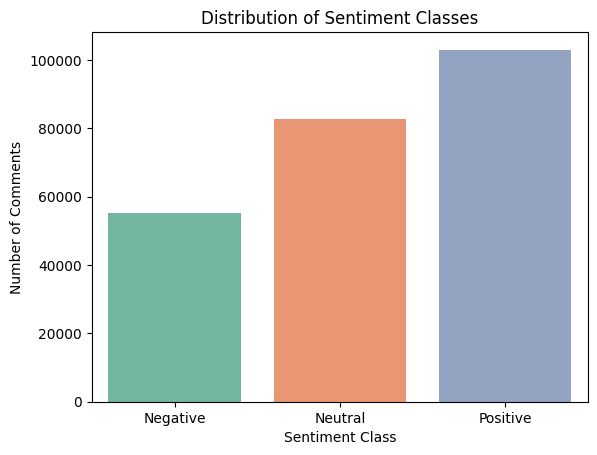

In [8]:
sns.countplot(x='Sentiment', data=active_data, palette='Set2')

plt.title("Distribution of Sentiment Classes")
plt.xlabel("Sentiment Class")
plt.ylabel("Number of Comments")
plt.xticks(ticks=[0, 1, 2], labels=["Negative", "Neutral", "Positive"])  
plt.show()

In [9]:
active_data['Sentiment'].value_counts(normalize=True) * 100

Sentiment
2    42.770454
1    34.357567
0    22.871978
Name: proportion, dtype: float64

The sentiment distribution in the dataset is slightly imbalanced:
- Positive: ~43%
- Neutral: ~34%
- Negative: ~23%

In [10]:
docs = list(nlp.pipe(active_data['Comment'], disable=["ner", "parser"]))
active_data['token_count'] = [len(doc) for doc in docs]

In [11]:
active_data['token_count'].describe()

count    240928.000000
mean         13.291444
std          10.621227
min           1.000000
25%           7.000000
50%          11.000000
75%          18.000000
max        1141.000000
Name: token_count, dtype: float64

In [12]:
active_data[active_data['token_count'] >= 512]

,Comment,Sentiment,token_count
3984,timestamps took forever intro ——————————— orig...,1,1141
10493,tracklist kanisan ft wishes dreams morning moo...,1,708
16407,description exclusive video footage panel star...,1,664
18276,introduction video speaker ml agenda core conc...,1,563


We analyzed the token count per comment and found only 4 comments exceeding 512 tokens — the standard maximum input size for transformer models like BERT. These outliers represent just ~0.0016% of the entire dataset.

Moreover, all 4 comments belong to the *positive* sentiment class, which is already the majority class in our dataset. 

Removing them not only avoids unnecessary complexity but also slightly improves class balance.

Therefore, we chose to drop these examples

In [13]:
active_data = active_data[active_data['token_count'] <= 512].reset_index(drop=True)

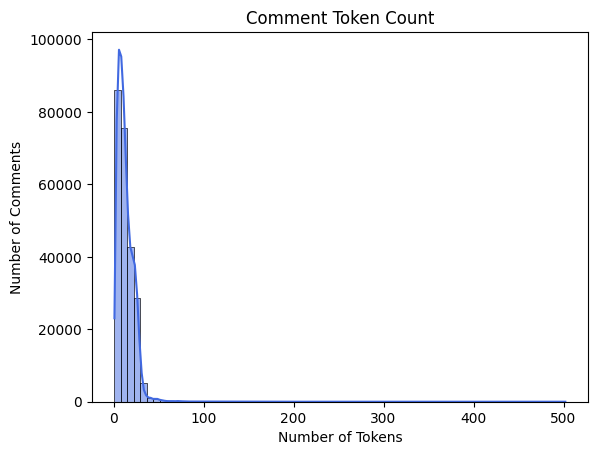

In [14]:
sns.histplot(active_data['token_count'], bins=70, kde=True, color='royalblue')
plt.title("Comment Token Count")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Comments")
plt.show()

In [15]:
active_data['token_count'].describe()

count    240924.000000
mean         13.278897
std          10.125150
min           1.000000
25%           7.000000
50%          11.000000
75%          18.000000
max         502.000000
Name: token_count, dtype: float64

After dropping the 4 extreme outliers, we re-evaluated the token length distribution..The maximum token length is now 502, which is within the standard 512-token limit of most transformer models.

While a few long comments remain, they are rare and pose no risk of truncation. Most comments fall well below 128 tokens. Therefore, we retain all remaining samples and proceed with a fixed `max_length` setting of 128 or 256 for consistent training.


In [16]:
active_data.head()

,Comment,Sentiment,token_count
0,lets forget apple pay required brand new iphon...,1,34
1,nz retailers don’t even contactless credit car...,0,20
2,forever acknowledge channel help lessons ideas...,2,16
3,whenever go place doesn’t take apple pay doesn...,0,58
4,apple pay convenient secure easy use used kore...,2,14


# Splitting Data

In [17]:
train_data, test_data = train_test_split(
    active_data,
    test_size=0.1,
    stratify=active_data['Sentiment'],
    random_state=42
)

train_data, val_data = train_test_split(
    train_data,
    test_size=0.1,  
    stratify=train_data['Sentiment'],
    random_state=42
)

In [18]:
print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")

Train size: 195147
Validation size: 21684
Test size: 24093


We split the dataset into training, validation, and test subsets using stratified sampling to ensure each class (negative, neutral, positive) is proportionally represented in all splits. This prevents bias from class imbalance and ensures that each split reflects the overall data distribution.

- 72% of data is used for training
- 8% is used for validation (model tuning & early stopping)
- 20% is reserved for final testing and evaluation

# Tokenization

In [19]:
train_ds = Dataset.from_pandas(train_data)
val_ds = Dataset.from_pandas(val_data)
test_ds = Dataset.from_pandas(test_data)

In [20]:
def preprocess_data(examples, tokenizer, max_length=128):
    tokens = tokenizer(
        examples["Comment"],
        truncation=True,
        padding="max_length",
        max_length=max_length
    )
    tokens["labels"] = examples["Sentiment"]  
    return tokens

In [21]:
def tokenize_and_save(tokenizer_name, train_ds, val_ds, test_ds, max_length=128):
    print(f"Tokenizing and saving datasets for {tokenizer_name}...")

    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

    tokenized_train = train_ds.map(lambda x: preprocess_data(x, tokenizer, max_length), batched=True)
    tokenized_val = val_ds.map(lambda x: preprocess_data(x, tokenizer, max_length), batched=True)
    tokenized_test = test_ds.map(lambda x: preprocess_data(x, tokenizer, max_length), batched=True)

    tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    tokenized_val.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    save_dir = f"/kaggle/working/tokenized_{tokenizer_name.replace('/', '_')}"

    tokenized_train.save_to_disk(os.path.join(save_dir, "train"))
    tokenized_val.save_to_disk(os.path.join(save_dir, "val"))
    tokenized_test.save_to_disk(os.path.join(save_dir, "test"))

    print(f"Datasets tokenized and saved under {save_dir}")

In [22]:
models = [
    "bert-base-uncased",
    "roberta-base",
    "distilbert-base-uncased",
    "vinai/bertweet-base"
]

for model_name in models:
    tokenize_and_save(model_name, train_ds, val_ds, test_ds, max_length=128)

Tokenizing and saving datasets for bert-base-uncased...


Saving the dataset (1/1 shards): 100%|██████████| 24093/24093 [00:00<00:00, 453636.22 examples/s]


Datasets tokenized and saved under /kaggle/working/tokenized_bert-base-uncased
Tokenizing and saving datasets for roberta-base...


Saving the dataset (1/1 shards): 100%|██████████| 24093/24093 [00:00<00:00, 538411.44 examples/s]


Datasets tokenized and saved under /kaggle/working/tokenized_roberta-base
Tokenizing and saving datasets for distilbert-base-uncased...


Saving the dataset (1/1 shards): 100%|██████████| 24093/24093 [00:00<00:00, 552029.23 examples/s]


Datasets tokenized and saved under /kaggle/working/tokenized_distilbert-base-uncased
Tokenizing and saving datasets for vinai/bertweet-base...


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Saving the dataset (1/1 shards): 100%|██████████| 24093/24093 [00:00<00:00, 436229.20 examples/s]


Datasets tokenized and saved under /kaggle/working/tokenized_vinai_bertweet-base


# Training Phase

In [23]:
class EpochLoggerAndBestModelCallback(TrainerCallback):
    def __init__(self, trainer=None, metric_name="eval_accuracy", output_dir="./best_model"):
        self.trainer = trainer
        self.metric_name = metric_name
        self.best_metric = None
        self.best_model_path = output_dir
        self.epoch_start_time = None
        os.makedirs(self.best_model_path, exist_ok=True)

    def on_epoch_begin(self, args, state, control, **kwargs):
        self.epoch_start_time = time.time()
        print(f"\n🟢 Epoch {int(state.epoch)+1}/{int(args.num_train_epochs)} started...")

    def on_epoch_end(self, args, state, control, logs=None, **kwargs):
        epoch_time = time.time() - self.epoch_start_time
        print(f"✅ Epoch {int(state.epoch)+1} finished in {epoch_time:.2f}s")

        if logs is None or self.metric_name not in logs:
            print("⚠️ Warning: No evaluation metrics found at epoch end.")
            return

        current_metric = logs[self.metric_name]
        print(f"\n📊 Epoch {int(state.epoch)+1} - {self.metric_name}: {current_metric}")

        if (self.best_metric is None) or (current_metric > self.best_metric):
            self.best_metric = current_metric
            print(f"🔥 New best {self.metric_name}: {self.best_metric} - saving model...")
            self.trainer.save_model(self.best_model_path)

    def on_train_end(self, args, state, control, **kwargs):
        print(f"\n✅ Training finished. Best {self.metric_name}: {self.best_metric}")
        print(f"📂 Best model saved at: {self.best_model_path}")

        # Load best model back into trainer.model
        if self.trainer is not None:
            self.trainer.model = self.trainer.model.from_pretrained(self.best_model_path)

In [24]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='macro', zero_division=0
    )
    
    return {
        "accuracy": acc,
        "macro_precision": precision,
        "macro_recall": recall,
        "macro_f1": f1
    }

In [25]:
def train_model(
    model_name,
    num_labels,
    train_dataset,
    val_dataset,
    num_epochs=3,
    train_batch_size=16,
    eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=500,
    output_root="./results",
    log_root="./logs"
):
    print(f"\n🚀 Starting training for model: {model_name}")

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_labels
    )

    model_tag = model_name.replace("/", "_")
    output_dir = f"{output_root}/{model_tag}"
    logging_dir = f"{log_root}/{model_tag}"

    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=learning_rate,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=eval_batch_size,
        num_train_epochs=num_epochs,
        weight_decay=weight_decay,
        metric_for_best_model="accuracy",
        logging_dir=logging_dir,
        logging_steps=logging_steps,
        save_total_limit=2,
        report_to="none"  
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EpochLoggerAndBestModelCallback()]
    )

    trainer.train()
    final_metrics = trainer.evaluate()
    print(f"\n📊 Final validation results for {model_tag}: {final_metrics}")
    return final_metrics

## BERT 

In [ ]:
model_name = "bert-base-uncased"
load_dir = f"/kaggle/working/tokenized_{model_name.replace('/', '_')}"

tokenized_train = load_from_disk(os.path.join(load_dir, "train"))
tokenized_val = load_from_disk(os.path.join(load_dir, "val"))
tokenized_test = load_from_disk(os.path.join(load_dir, "test"))

bert_metrics=train_model(model_name, 3, tokenized_train, tokenized_val)


🚀 Starting training for model: bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
E0000 00:00:1750643083.695158      10 common_lib.cc:621] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:232



🟢 Epoch 1/3 started...


Step,Training Loss


## distlibert 

In [ ]:
model_name = "distilbert-base-uncased"
load_dir = f"/kaggle/working/tokenized_{model_name.replace('/', '_')}"

tokenized_train = load_from_disk(os.path.join(load_dir, "train"))
tokenized_val = load_from_disk(os.path.join(load_dir, "val"))
tokenized_test = load_from_disk(os.path.join(load_dir, "test"))

distlibert_metrics=train_model(model_name, 3, tokenized_train, tokenized_val)

## roberta 

In [ ]:
model_name = "roberta-base"
load_dir = f"/kaggle/working/tokenized_{model_name.replace('/', '_')}"

tokenized_train = load_from_disk(os.path.join(load_dir, "train"))
tokenized_val = load_from_disk(os.path.join(load_dir, "val"))
tokenized_test = load_from_disk(os.path.join(load_dir, "test"))

roberta_metrics=train_model(model_name, 3, tokenized_train, tokenized_val)

## Bertweet

In [ ]:
model_name = "vinai/bertweet-base"
load_dir = f"/kaggle/working/tokenized_{model_name.replace('/', '_')}"

tokenized_train = load_from_disk(os.path.join(load_dir, "train"))
tokenized_val = load_from_disk(os.path.join(load_dir, "val"))
tokenized_test = load_from_disk(os.path.join(load_dir, "test"))

bertweet_metrics=train_model(model_name, 3, tokenized_train, tokenized_val)

## Comparting Models

In [ ]:
metrics_list = [
    {**bert_metrics, "model": "bert-base-uncased"},
    {**roberta_metrics, "model": "roberta-base"},
    {**distlibert_metrics, "model": "distilbert-base-uncased"},
    {**bertweet_metrics, "model": "vinai/bertweet-base"}
]
df = pd.DataFrame(metrics_list)

In [ ]:
df = df.sort_values(by="macro_f1", ascending=False)

In [ ]:
df = df[['model', 'accuracy', 'macro_precision', 'macro_recall', 'macro_f1']]

In [ ]:
df